## 0 - Introduction  

### Tutorial purpose
To give you a clear overview of a basic machine learning workflow and to introduce you to the two (arguably) most fundamental classification methods: logistic regression and k-nearest neighbors.

### Learning outcomes  

After finishing this tutorial, you will be able to,  

1. Understand the basic workflow of a machine learning based classification application;
2. Implement a basic classification workflow using open source software;
3. Interpret the results of a basic classification application.

### Tutorial contents
The tutorial will cover the following topics with relevant R codes:

1. Data processing;
2. Model building  
-- K-nearest neighbors;  
-- Random forests;  
-- Confusion matrix;  
3. Cross-validation;  
4. Model selection;  
5. Binary and multiclass classification;  

### About the data sets  
The data set is a snapshot by Landsat-8 OLI of Asheville, North Carolina taken from Landsat 8. The reference data we are using is the Cropland Data Layer (CDL) data from UDSA. It provides the land cover/land use types of each pixel for the same region. There is also a comma-separated values (CSV) file contains the set of random samples within the region with reference CDL land cover information and corresponding reflectance values for model training and evaluation. 

Check out the following links for more information:  

[Landsat-8 OLI data](https://www.usgs.gov/land-resources/nli/landsat/landsat-8?qt-science_support_page_related_con=0#qt-science_support_page_related_con)

[USDA Cropland Data Layer (CDL)](https://nassgeodata.gmu.edu/CropScape/)

## 1 - Data processing  

Before we starts to read in the data, we need to load libraries that will be used in the notebook. We will heavily rely on [**caret**](https://topepo.github.io/caret/index.html) library in R for model training. *caret* is a powerful wrapper package which calls hunders of machine learning packages in R and it simplify model training and application process. The pacakge currently supports 238 models that can be implemented in R using the same *train* and *prediction* procedures.  

In [3]:
library(caret); library(e1071); library(ranger)             # pacakge for ML model
library(ggplot2); library(cowplot)                                # package for visualization
library(readr); library(dplyr); library(raster)                   # package for data handeling


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: sp


Attaching package: ‘raster’


The following object is masked from ‘package:dplyr’:

    select


The following object is masked from ‘package:e1071’:

    interpolate




### 1.1 - Data ingest 

First thing first, we will read in the data for this notebook which is included in this Github repository. The data file [*NC_L8_GroundTruth.csv*](https://github.com/geo-yrao/ML4ES-tutorials/blob/master/NC_L8_GroundTruth.csv) contains sampled pixels in western North Carolina. The data contains both the multispectral reflectance from Landsat-8 OLI data and corresponding land cover types from USGS Cropland Data Layer (CDL).

In [5]:
## Here, we read in the data pairs between reflectance (scale factor: 0.0001) and land cover types
# fname <- "~/NC_L8_GroundTruth.csv"
fname <- "~/classification/NC_L8_GroundTruth.csv"
AVLData <- read_csv(fname); AVLData$Class <- factor(AVLData$Class, labels = c("Forest", "Corn", "Soy", "Urban", "Water"))

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  X1 = col_double(),
  Latitude = col_double(),
  Longitude = col_double(),
  Class = col_double(),
  B1 = col_double(),
  B2 = col_double(),
  B3 = col_double(),
  B4 = col_double(),
  B5 = col_double(),
  B6 = col_double()
)



### 1.2 - Data exploration

Our data contains the location (*"Latitude","Longitude"*), land cover type (*"Class"*), and reflectance of six OLI channels (*"B1"~"B6"*). Let's first check how the data frame looks like.

In [ ]:
## We can show the first 10 rows of the data frame 
head(AVLData, 10)

The following table present the information about the six [OLI chanles](https://en.wikipedia.org/wiki/Landsat_8) included in the data. The reflectance data can provide unique information to charaterize different land cover types.

| Channel No. | Channel Name | Wavelength |
|-:|-:|:-:|
|B1|Coastal/Areasol|0.433 – 0.453 μm| 
|B2|Blue|0.450 – 0.515 μm|
|B3|Green|0.525 – 0.600 μm|
|B4|Red|0.630 – 0.680 μm|
|B5|Near Infrared|0.845 – 0.885 μm|
|B6|Short Wavelength Infrared|1.560 – 1.660 μm|

### 1.3 - Viewing class historgram  

We want to understand how many samples belong to each class. In our data, there are five different classes as listed in the table below. This information can be found in the file *"label_information.txt"*.  

| Class No. | Land Cover Type |
|-:|-:|
|0|Forest| 
|1|Corn|
|2|Soy|
|3|Development/Urban|
|4|Water| 

Here, we create a histogram to examing the histogram of land cover types in the data.

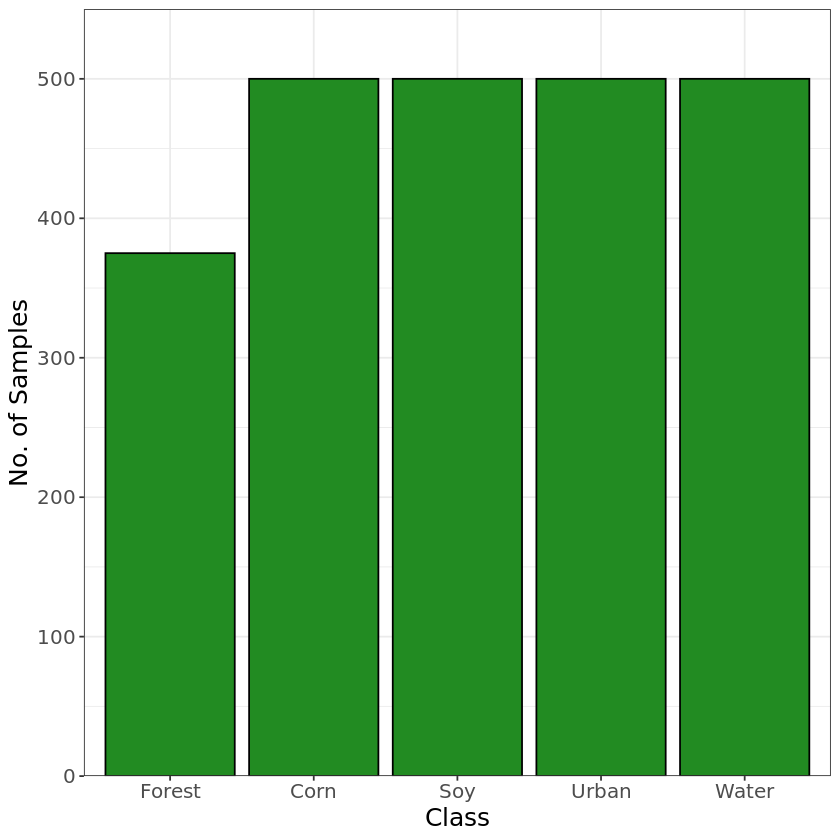

In [6]:
# Show the histogram of different land cover types using ggplot2
AVLData %>% ggplot() + geom_bar(aes(Class), color="black", fill="forestgreen") +
  labs(x="Class", y="No. of Samples") + scale_y_continuous(lim=c(0,550), expand=c(0,0)) +
  theme_bw() + theme(text=element_text(size=15))

As you can see, the data is overall well balanced across different classes except for forest (*Class == 0*). 

### 1.4 - Feature space  

Before we dive into model training, we can examine the features (i.e., reflectance) that will be used for building the classifier. We use Channel 2 and 5 as an example. Please consider modify the code below to explore different feature combinations.  


In [ ]:
## We use ggplot2 again here to plot the scatter plot of B2 and B5
AVLData %>% ggplot(aes(x=B2,y=B5)) + geom_point(aes(color=Class), pch=21, size=2) + theme_bw() +
  coord_cartesian(xlim=c(0, 3000), ylim=c(0, 6000), expand=F) + 
  scale_color_manual(values = c("forestgreen", "orange", "purple", "grey25", "royalblue")) + 
  labs(x = "Band 2", y = "Band 5") +  theme(text=element_text(size=15))

It looks like the forest/corn/soy can be easily separated from urban and water, while it might be diffcult to distinguish forest, soy, and corn from each other. This is reasonable since all vegetation share similar spectral signatures that are unique comparing to water and urban classes. But the spectral differences between different vegetation types could be small in certain feature combinations. In the next code chunk, please try to modify the code to see other feature combinations (e.g., B2 v.s. B6).

In [ ]:
### Consider how you can modify the code from last chunk and create a new scatter plot between B2 and B6;
### What does the feature space look like? Can you distinguish different classes here?


To build our classification model, we first need to **split the data** into different sets for model development and testing. Let's follow the convention ratio of data spliting -- 80% for model development and 20% for testing. We will implement cross validation in the training using the model development dataset. 

There are different ways to implement data splitting. In our case, we want to make sure that all classes are well represented in both data sets. Idealy, we want both data sets can reflect on the "reality" so we will use stratified spliting.

Warning message:
“The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


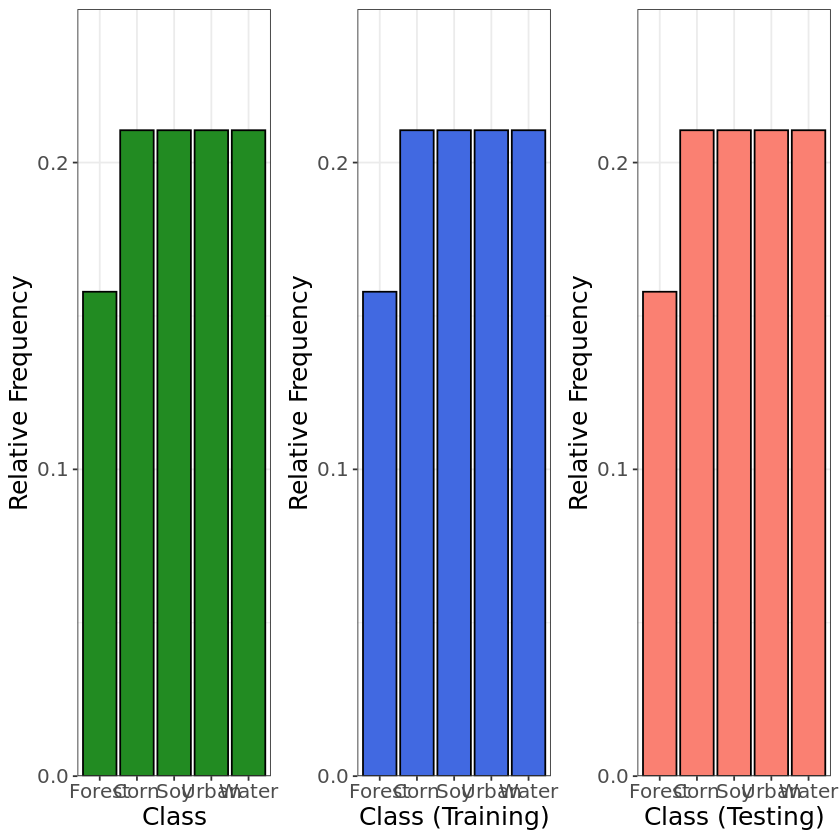

In [7]:
## spliting the data based on the outcome -- classes; 80% for modeling, 20% for testing.
## This is the default spliting methonds in caret via function createDataPartition
## to learn more about the function, try "? createDataPartition"

## In order to make sure the data partition can be reproduced, we set the seed number before partition, 
## so the psudo random number is fixed for each execution
set.seed(982)
trainIndex <- createDataPartition(AVLData$Class, p=0.8, list=FALSE, times = 1)
trainData  <- AVLData[trainIndex,]; testData <- AVLData[-trainIndex,]

## Compare the relative frequency for both dataset with the original data using ggplot2
p1 <- AVLData %>% ggplot() + labs(x="Class", y="Relative Frequency") + theme_bw() + 
  geom_bar(aes(Class, y=..count../nrow(AVLData)), color="black", fill="forestgreen") +
  scale_y_continuous(lim=c(0,0.25), breaks = seq(0,0.3,0.1), expand=c(0,0)) +
  theme(text=element_text(size=15)) ## ploting for overall data
p2 <- trainData %>% ggplot() + labs(x="Class (Training)", y="Relative Frequency") + 
  geom_bar(aes(Class, y=..count../nrow(trainData)), color="black", fill="royalblue") +
  scale_y_continuous(lim=c(0,0.25), breaks = seq(0,0.3,0.1), expand=c(0,0)) +
  theme_bw() + theme(text=element_text(size=15)) ## ploting for training data
p3 <- testData %>% ggplot() + labs(x="Class (Testing)", y="Relative Frequency") + 
  geom_bar(aes(Class, y=..count../nrow(testData)), color="black", fill="salmon") +
  scale_y_continuous(lim=c(0,0.25), breaks = seq(0,0.3,0.1), expand=c(0,0)) +
  theme_bw() + theme(text=element_text(size=15)) ## ploting for testing data

## putting three plots together via cowplot::plot_grid function
cowplot::plot_grid(p1,p2,p3, nrow=1, ncol=3)

How would this splitting different from simple random spliting? Let's see the difference!  


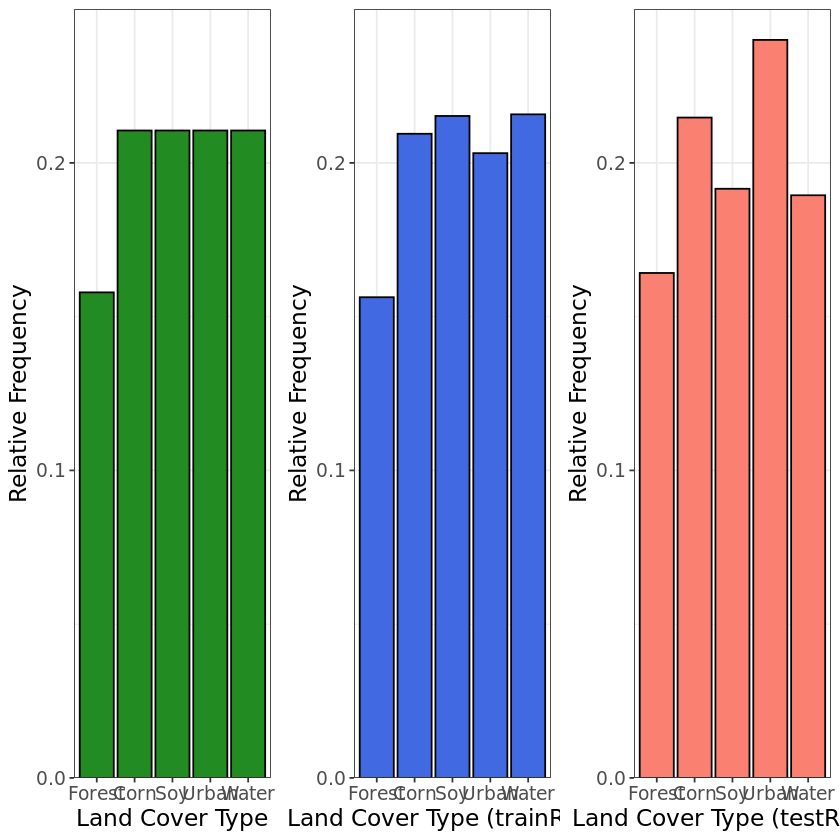

In [8]:
set.seed(798)
nobs <- nrow(AVLData)  # this get the total number of samples
randIndex <- sample(1:nobs, nobs*0.8); # First, we generate the random index for simple random sampling 80%:20%
trainRand <- AVLData[ randIndex,]; testRand <- AVLData[-randIndex,] ## simple random spliting dataset

## let's see the comparison of the relative frequency again
## Compare the relative frequency data for both dataset with the original data
p1 <- AVLData %>% ggplot() + labs(x="Land Cover Type", y="Relative Frequency") + 
  geom_bar(aes(Class, y=..count../nrow(AVLData)), color="black", fill="forestgreen") +
  scale_y_continuous(lim=c(0,0.25), breaks = seq(0,0.3,0.1), expand=c(0,0)) +
  theme_bw() + theme(text=element_text(size=14)) ## ploting for overall data
p2 <- trainRand %>% ggplot() +  labs(x="Land Cover Type (trainRand)", y="Relative Frequency") + 
  geom_bar(aes(Class, y=..count../nrow(trainRand)), color="black", fill="royalblue") +
  scale_y_continuous(lim=c(0,0.25), breaks = seq(0,0.3,0.1), expand=c(0,0)) +
  theme_bw() + theme(text=element_text(size=14)) ## ploting for training data
p3 <- testRand %>% ggplot() + labs(x="Land Cover Type (testRand)", y="Relative Frequency") +
  geom_bar(aes(Class, y=..count../nrow(testRand)), color="black", fill="salmon") +
  scale_y_continuous(lim=c(0,0.25), breaks = seq(0,0.3,0.1), expand=c(0,0)) +
  theme_bw() + theme(text=element_text(size=14)) ## ploting for testing data

## putting three plots together via cowplot
cowplot::plot_grid(p1,p2,p3, nrow=1, ncol=3)

We can see the difference on the relative frequency in training and testing datasets, which is something that we want to avoid when we are partitioning the data for model development. In extreme cases, the imbalance sample could lead to unreliable model training and/or testing results. We will not explore the impact in this tutorial. [This article](https://machinelearningmastery.com/what-is-imbalanced-classification/) provides a good overview of imbalanced classification problem in machine learning.

### 1.6 - Simpilying to a binary classification example  

As our first classifier, let's focus on a binary classifier example. So we first keep samples of forests (*Class == 0*) and water (*Class == 4*). We will implement the multiclass classification later.


In [9]:
## We use filter function from dplyr to screen the data
binData <- AVLData %>% filter(Class == "Forest" | Class == "Water") 
binTrain <- trainData %>% filter(Class=="Forest" | Class=="Water"); binTrain$Class <- droplevels(binTrain$Class)
binTest  <- testData  %>% filter(Class=="Forest" | Class=="Water"); binTest$Class <- droplevels(binTest$Class)

## 2 - Model building 

### 2.1 - K-nearest neighbor (k-NN)

Now we have training and testing data ready, let's creat our first classifier, [**k-nearest neighbor (k-NN)**](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm). It is probably one of the most intuitive classification models. k-NN assumes that the class of a given unknow data point is determined by the classes of its closest "neighbors" in the feature space. There is one hyperparameter that need to be determined by us, which is the number of neighbors (__*k*__) used to determine the class of any data points.  

There are different variations of k-NN model which are developed to improve its performance for different challenging tasks. But here we will use the classic k-NN model. In *caret* package, the k-NN model is represented using the tag *"knn"*. 

In [10]:
## In R, you can simply get the model information using the function *getModelInfo* provided by *caret* package.
## check how to use function getModelInfo
? getModelInfo
## check the specifics of the model k-NN. Since there are many different variations of k-NN, we want to match the model tag exactly by turning off the regular expression match.
getModelInfo(model="knn",regex=FALSE)

parameter,class,label
<chr>,<chr>,<chr>
k,numeric,#Neighbors


This model information tells us that there is only one model hyperparameter need to be specified to train a k-NN model. To start with the model, we will simply use _**k = 9**_ for our first k-NN model without any cross-validation. 

In [11]:
set.seed(998)
## To start our model, we will fix k = 9 without cross validation

## In *caret*, the function **trainControl** compiles the model training process.
## trainControl function sepecifies whether and how to train your model
## you can use "? trainControl" to find out more information 
## or visit this webpage: https://topepo.github.io/caret/model-training-and-tuning.html#basic-parameter-tuning

knnControl <- trainControl(method = "none", classProbs = TRUE) ## here, we specify no cross validation

## using train function to train the model
knnClassifier <- train(Class ~ B1 + B2 + B3 + B4 + B5 + B6, data = binTrain, method = "knn", 
                 trControl = knnControl, tuneGrid = data.frame(k=9)) ## fix k value as 9

knnClassifier

k-Nearest Neighbors 

700 samples
  6 predictor
  2 classes: 'Forest', 'Water' 

No pre-processing
Resampling: None 

### 2.2 - Generate confusion matrix  

Just like that, we have our k-NN classifier. How did our model do? We can find out using the confusion matrix, the best way to evaluation a classification model by tabulating the model generated classes against the reference classes as a matrix.  

In [12]:
## First, we can extract the predicted class of our k-nn (k=9) model
predClass <- predict(knnClassifier)
## Now, we can combine the predicted class and true class in the trainData to construct our confusion matrix
knnMatrix <- confusionMatrix(predClass, binTrain$Class)
knnMatrix

Confusion Matrix and Statistics

          Reference
Prediction Forest Water
    Forest    292    21
    Water       8   379
                                         
               Accuracy : 0.9586         
                 95% CI : (0.941, 0.9721)
    No Information Rate : 0.5714         
    P-Value [Acc > NIR] : < 2e-16        
                                         
                  Kappa : 0.9159         
                                         
 Mcnemar's Test P-Value : 0.02586        
                                         
            Sensitivity : 0.9733         
            Specificity : 0.9475         
         Pos Pred Value : 0.9329         
         Neg Pred Value : 0.9793         
             Prevalence : 0.4286         
         Detection Rate : 0.4171         
   Detection Prevalence : 0.4471         
      Balanced Accuracy : 0.9604         
                                         
       'Positive' Class : Forest         
                                   

From the output of our confusion matrix, we get a quite good k-NN model with overall accuracy of classification (**a=0.9586**). Only 29 samples were misclassified in this model.

### 2.3 - Random forest  

There are more sophiscated model that we can use to address more sophisicated classification problem. Here, we choose to introduce [random forest](https://en.wikipedia.org/wiki/Random_forest) model because of it robust performance in many applications. The random forest is an ensemble learning model by creating a suite of decision trees at training time and outputting the class that is the majority of the classes from each individual tree for classification problem. The fundamental idea of random forest  model is that the collective power of multiple "weak" models can outperform any individual "strong" model. It can address overfitting issue comparing to the regular decision tree model.  

Similar with k-NN, there are different flavors of random forest model. We are using the classic random forest model with *caret* package with the tag *"ranger"*. As the model gets more complicated, we have more to consider about the model structure, such as, how many variables we want to have as input for each tree (*mtry*), the depth of a decision tree (*min.node.size*). These could all have potential impact on our final model outcomes. 

In [13]:
## we can still get the model info using getModelInfo()
# getModelInfo("ranger", regex=FALSE)

## Let's fixed the number of predictors that we want to use as 4 and number of min.node.size=1
## still we do not do a cross validation now
rfControl <- trainControl(method = "none", classProbs = TRUE)

set.seed(973)

## Train the random forest model using train function 
rfClassifier <- train(Class ~ B1 + B2 + B3 + B4 + B5 + B6, data = binTrain, method = "ranger", 
                 trControl = rfControl, tuneGrid = data.frame(mtry=4, min.node.size=1, splitrule="gini")) 
## fix mtry=4, min.node.size=1, splitrule="gini"

## with the trained random forest, let's see the confusion matrix here
predClass <- predict(rfClassifier)
## Now, we can combine the predicted class and true class in the binTrain to construct our confusion matrix
rfMatrix <- confusionMatrix(predClass, binTrain$Class)
rfMatrix

Confusion Matrix and Statistics

          Reference
Prediction Forest Water
    Forest    300     0
    Water       0   400
                                     
               Accuracy : 1          
                 95% CI : (0.9947, 1)
    No Information Rate : 0.5714     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.4286     
         Detection Rate : 0.4286     
   Detection Prevalence : 0.4286     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : Forest     
                                     

It looks like random forest did a perfect job on separating these two classes in the training data with an overall accuracy of 1. But is it too good to be true? 

### 2.4 - Evaluate model using testing data  

In order to make sure this performance is not just for the training data, we need to evaluate our random forest model on the independent testing data that we set aside at the beginning.  

In [14]:
## Applying our k-NN and random forest model to our binTest & generate confusion matrix for testing data
knnTest <- predict(knnClassifier, newdata = binTest)
knnMatrixTest <- confusionMatrix(knnTest, binTest$Class)

print("Testing Confusion Matrix for binary k-NN classification model")
knnMatrixTest

rfTest <- predict(rfClassifier, newdata = binTest)
rfMatrixTest <- confusionMatrix(rfTest, binTest$Class)

print("Testing Confusion Matrix for binary random forest classification model")
rfMatrixTest

[1] "Testing Confusion Matrix for binary k-NN classification model"


Confusion Matrix and Statistics

          Reference
Prediction Forest Water
    Forest     73     5
    Water       2    95
                                          
               Accuracy : 0.96            
                 95% CI : (0.9193, 0.9838)
    No Information Rate : 0.5714          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9187          
                                          
 Mcnemar's Test P-Value : 0.4497          
                                          
            Sensitivity : 0.9733          
            Specificity : 0.9500          
         Pos Pred Value : 0.9359          
         Neg Pred Value : 0.9794          
             Prevalence : 0.4286          
         Detection Rate : 0.4171          
   Detection Prevalence : 0.4457          
      Balanced Accuracy : 0.9617          
                                          
       'Positive' Class : Forest          
               

[1] "Testing Confusion Matrix for binary random forest classification model"


Confusion Matrix and Statistics

          Reference
Prediction Forest Water
    Forest     72     4
    Water       3    96
                                          
               Accuracy : 0.96            
                 95% CI : (0.9193, 0.9838)
    No Information Rate : 0.5714          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9185          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9600          
            Specificity : 0.9600          
         Pos Pred Value : 0.9474          
         Neg Pred Value : 0.9697          
             Prevalence : 0.4286          
         Detection Rate : 0.4114          
   Detection Prevalence : 0.4343          
      Balanced Accuracy : 0.9600          
                                          
       'Positive' Class : Forest          
               

It looks like the testing performance of the k-NN model and random forest model is equally good with the same overall accuracy 0.96, which is still a job well done! But can we improve the model performance by changing the hyperparameters that we set as fixed values?

## 3- Cross validation 

To explore the optimum combination of the model hyperparameters, we typically uses the cross validation (CV) strategy. There are different type of cross validation strategy, such as, k-fold cross validation, leave-one-out cross validation, repeated cross validation. More information can be found in this [well written article about the importance of CV for machine learning](https://www.digitalvidya.com/blog/cross-validation-in-machine-learning/).  

The most commonly used CV strategy is usually [k-fold CV](https://machinelearningmastery.com/k-fold-cross-validation/). But it still depends on the data that have for your problem. If you are using time series data, your cross validation strategy will be different since you want to account for the tempooral autocorrelation within your data. Same idea applies when your data have strong spatial auto correlation. But today, let's assume that k-fold CV can solve our problem. 

### 3.1 k-fold cross validation

We can use a 10-fold CV to find the optimum hyperparameters for our two classification models (i.e., k-NN and random forest). 

'data.frame':	7 obs. of  1 variable:
 $ k: num  3 5 7 9 11 13 15
[1] "10-fold Cross Validation for binary k-NN classification"


k-Nearest Neighbors 

700 samples
  6 predictor
  2 classes: 'Forest', 'Water' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 630, 630, 630, 630, 630, 630, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   3  0.9514286  0.9014513
   5  0.9542857  0.9071425
   7  0.9542857  0.9073310
   9  0.9500000  0.8985935
  11  0.9471429  0.8926880
  13  0.9414286  0.8808278
  15  0.9414286  0.8808777

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 7.

Cross-Validated (10 fold) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction Forest Water
    Forest   41.4   3.1
    Water     1.4  54.0
                            
 Accuracy (average) : 0.9543


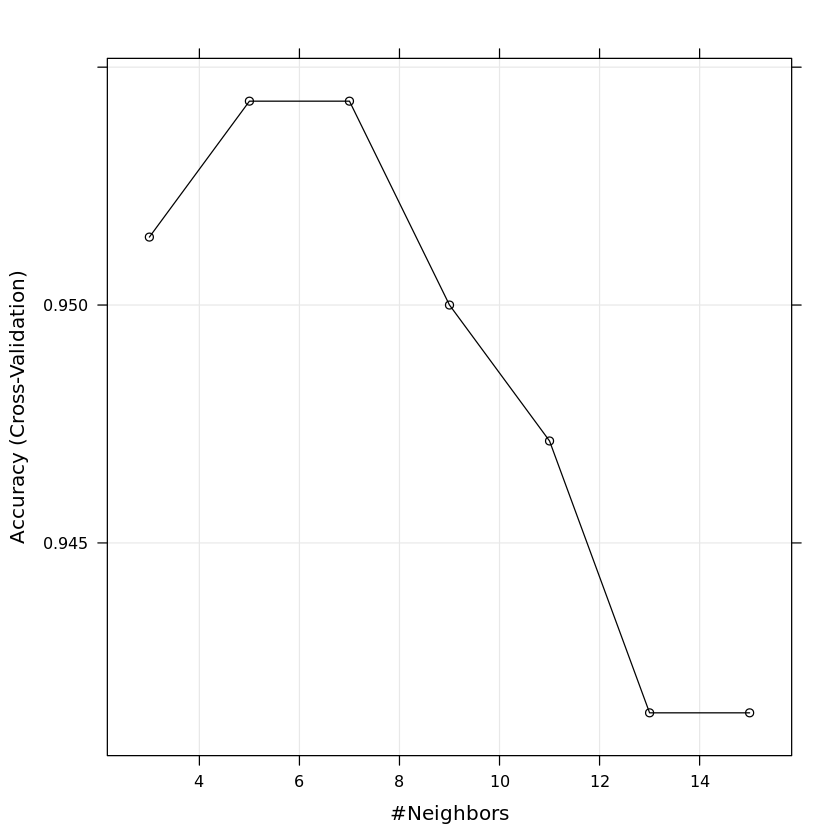

In [15]:
## here, we modify the trainControl function to use 10-fold cross-validation 
cvControl <- trainControl(method="cv", number = 10)

## we also need to specify the grid we want the hyperparameter tuning to search
knnGrid <- data.frame(k = seq(3,15,2)); str(knnGrid)

set.seed(982)
## Now, we can implement the cross-validation using train function
knnCV <- train(Class ~ B1 + B2 + B3 + B4 + B5 + B6, data = binTrain, method = "knn", 
               trControl = cvControl, tuneGrid = knnGrid)

## Here is how our the cross-validation output looks like for the k-NN
print("10-fold Cross Validation for binary k-NN classification")
knnCV

## we can see the average performance of the cross validation via confusion matrix
confusionMatrix(knnCV)

## We can plot the accuracy as a function of different k values to assist our selection of the hyperparameter
trellis.par.set(caretTheme())  ## here, we set the them for the plot
plot(knnCV) 

It shows us the k-NN model reaches the best performance when k is set to **7** with the highest overall accuracy.

Now, we can do the same thing for the random forest model we just developed but with more hyperparameters to adjust for.

'data.frame':	16 obs. of  3 variables:
 $ mtry         : num  2 3 4 5 2 3 4 5 2 3 ...
 $ min.node.size: num  1 1 1 1 3 3 3 3 5 5 ...
 $ splitrule    : Factor w/ 1 level "gini": 1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, "out.attrs")=List of 2
  ..$ dim     : Named int  4 4 1
  .. ..- attr(*, "names")= chr  "mtry" "min.node.size" "splitrule"
  ..$ dimnames:List of 3
  .. ..$ mtry         : chr  "mtry=2" "mtry=3" "mtry=4" "mtry=5"
  .. ..$ min.node.size: chr  "min.node.size=1" "min.node.size=3" "min.node.size=5" "min.node.size=7"
  .. ..$ splitrule    : chr "splitrule=gini"
[1] "10-fold Cross Validation for binary random forest classification"


Random Forest 

700 samples
  6 predictor
  2 classes: 'Forest', 'Water' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 630, 630, 630, 630, 630, 630, ... 
Resampling results across tuning parameters:

  mtry  min.node.size  Accuracy   Kappa    
  2     1              0.9542857  0.9072377
  2     3              0.9528571  0.9043820
  2     5              0.9542857  0.9071665
  2     7              0.9514286  0.9014305
  3     1              0.9528571  0.9043829
  3     3              0.9542857  0.9073344
  3     5              0.9528571  0.9042862
  3     7              0.9557143  0.9102628
  4     1              0.9528571  0.9043080
  4     3              0.9557143  0.9102389
  4     5              0.9528571  0.9043340
  4     7              0.9528571  0.9044290
  5     1              0.9557143  0.9102389
  5     3              0.9585714  0.9160481
  5     5              0.9557143  0.9102389
  5     7              0.9542857  0.9073586

Tuning parame

Cross-Validated (10 fold) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction Forest Water
    Forest   41.6   2.9
    Water     1.3  54.3
                            
 Accuracy (average) : 0.9586


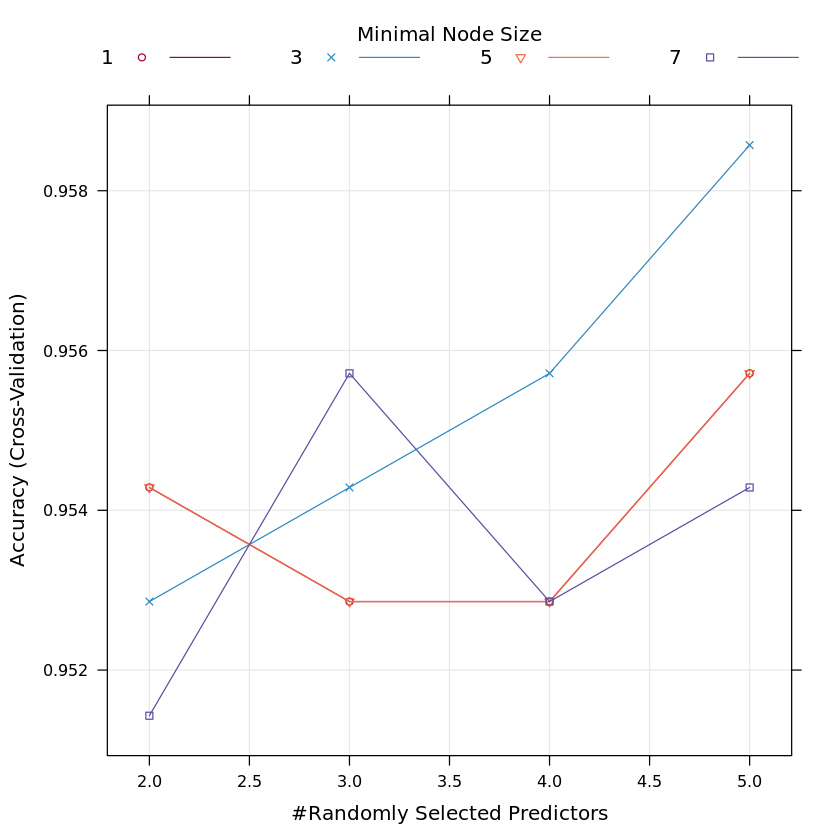

In [16]:
## here, we modify the trainControl function to use 10-fold cross-validation 
cvControl <- trainControl(method="cv", number = 10)

## we also need to specify the grid we want the hyperparameter tuning to search
rfGrid <- expand.grid(mtry = seq(2,5,1), min.node.size=seq(1,7,2), splitrule="gini"); 
str(rfGrid)

set.seed(982)
## Now, we can implement the cross-validation using train function
rfCV <- train(Class ~ B1 + B2 + B3 + B4 + B5 + B6, data = binTrain, method = "ranger", 
              trControl = cvControl, tuneGrid = rfGrid)

## Here is how our the cross-validation output looks like for the k-NN
print("10-fold Cross Validation for binary random forest classification")
rfCV

## we can see the average performance of the cross validation via confusion matrix
confusionMatrix(rfCV)

## We can plot the accuracy as a function of different hyperparameter to assist our selection of the hyperparameter
trellis.par.set(caretTheme())  ## here, we set the them for the plot
plot(rfCV) 

You may have noticed that the overall accuracy number in the cross-validation for random forest is different from the training accuracy earlier. That's because cross-validation reports the performance of the model based on the average performance of all (5) models on the hold-out dataset. It is not the training accuracy as we see before.  
But the corss validation results inform us that the random forest model performs best when the maximum number of variables used for individual tree (*mtry*) should be **5** and the minimum number of samples within a branch of the decision tree (*min.node.size*) should be **3**.  

## 4 - Model selection

Now, we have two binary classification models - a k-NN classifier and a random forest classifier. Given these models, can we make statistical statements about their performance differences, thus leading us to the decision which model shall we use?


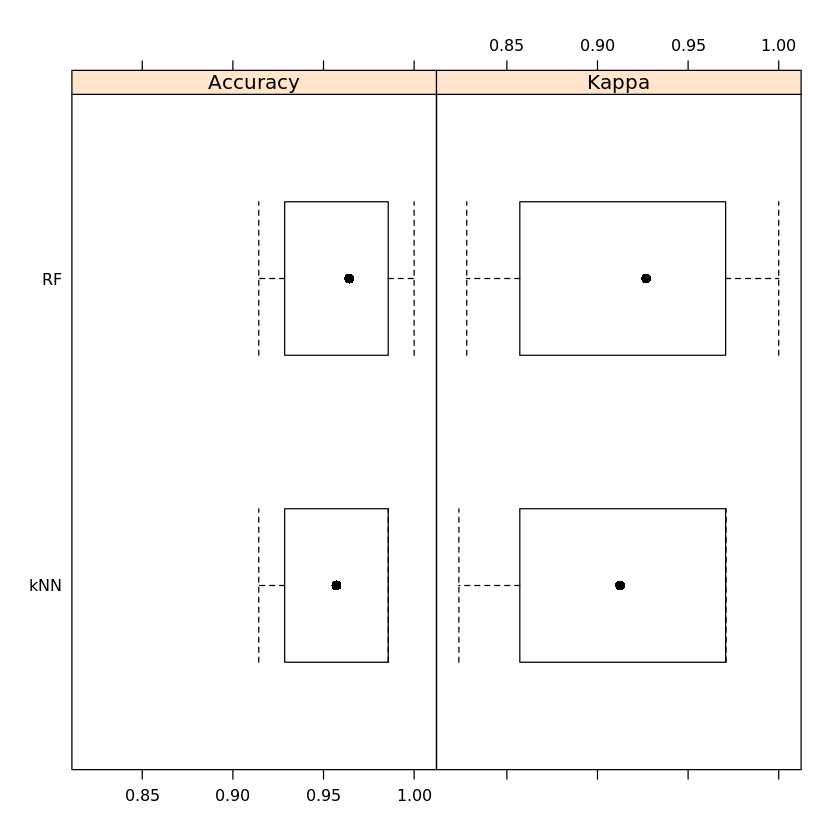

In [17]:
## We can first create a list of resamples from previous cross validation results
resModels <- resamples(list(kNN = knnCV, RF = rfCV))

## Now we can visualize the differences of these two models
## First, let's set the theme for the plot
theme1 <- trellis.par.get()
theme1$plot.symbol$col = rgb(.2, .2, .2, .4)
theme1$plot.symbol$pch = 16
theme1$plot.line$col = rgb(1, 0, 0, .7)
theme1$plot.line$lwd <- 2
trellis.par.set(theme1)
bwplot(resModels, layout = c(2, 1))


From the boxplot, it seems like that there is slight edge of random forest (RF) over k-NN based on the cross-vdalition results. We can also apply both model to the independent testing dataset.

In [18]:

## apply the model to our testing data
knnCVTest <- predict(knnCV, newdata = binTest)
rfCVTest  <- predict(rfCV , newdata = binTest)

## generate the confusion matrix for the testing data
knnCVMatrix <- confusionMatrix(knnCVTest, binTest$Class)
 rfCVMatrix <- confusionMatrix( rfCVTest, binTest$Class)
 
print(" Testing confusion matrix for k-NN classification ")
knnCVMatrix

print(" Testing confusion matrix for random forest classification ")
rfCVMatrix


[1] " Testing confusion matrix for k-NN classification "


Confusion Matrix and Statistics

          Reference
Prediction Forest Water
    Forest     73     4
    Water       2    96
                                          
               Accuracy : 0.9657          
                 95% CI : (0.9269, 0.9873)
    No Information Rate : 0.5714          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9302          
                                          
 Mcnemar's Test P-Value : 0.6831          
                                          
            Sensitivity : 0.9733          
            Specificity : 0.9600          
         Pos Pred Value : 0.9481          
         Neg Pred Value : 0.9796          
             Prevalence : 0.4286          
         Detection Rate : 0.4171          
   Detection Prevalence : 0.4400          
      Balanced Accuracy : 0.9667          
                                          
       'Positive' Class : Forest          
               

[1] " Testing confusion matrix for random forest classification "


Confusion Matrix and Statistics

          Reference
Prediction Forest Water
    Forest     72     4
    Water       3    96
                                          
               Accuracy : 0.96            
                 95% CI : (0.9193, 0.9838)
    No Information Rate : 0.5714          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9185          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9600          
            Specificity : 0.9600          
         Pos Pred Value : 0.9474          
         Neg Pred Value : 0.9697          
             Prevalence : 0.4286          
         Detection Rate : 0.4114          
   Detection Prevalence : 0.4343          
      Balanced Accuracy : 0.9600          
                                          
       'Positive' Class : Forest          
               

Both of them acheives similar overall accuracy for the binary classification tasks (~0.96). This is reasonable as we have seen in the scatter plot earlier they are pretty separable. How would these two models performs for multiclass classification?  

## 5 - Multiclass classification  

Now, let's try to build the multiclass classifier using 10-fold cross validation via k-nn (for the compuation efficiency reason). 

In [19]:
cvControl <- trainControl(method="cv", number = 10) ## 10-fold cross validation

## since we have five classes in the data, let's increase the number of neighbors since we might need more opinion for each class
knnGrid <- expand.grid(k=seq(5,25,2)); str(knnGrid)

set.seed(982)
## Train our k-nn model
knnMulti <- train(Class ~ B1 + B2 + B3 + B4 + B5 + B6, data = trainData, method = "knn", 
                  trControl = cvControl, tuneGrid = knnGrid)

confusionMatrix(knnMulti)

'data.frame':	11 obs. of  1 variable:
 $ k: num  5 7 9 11 13 15 17 19 21 23 ...
 - attr(*, "out.attrs")=List of 2
  ..$ dim     : Named int 11
  .. ..- attr(*, "names")= chr "k"
  ..$ dimnames:List of 1
  .. ..$ k: chr  "k= 5" "k= 7" "k= 9" "k=11" ...


Cross-Validated (10 fold) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction Forest Corn  Soy Urban Water
    Forest   12.7  1.2  0.4   3.3   0.8
    Corn      0.7  9.6  6.9   2.4   0.1
    Soy       0.7  7.9 11.2   2.7   0.1
    Urban     0.9  2.3  2.6  12.1   0.5
    Water     0.7  0.1  0.0   0.5  19.6
                            
 Accuracy (average) : 0.6521


The 10-fold CV tells us that when **k=13** we got the best overall accuracy. Let's look at what the model performance look like this time.  


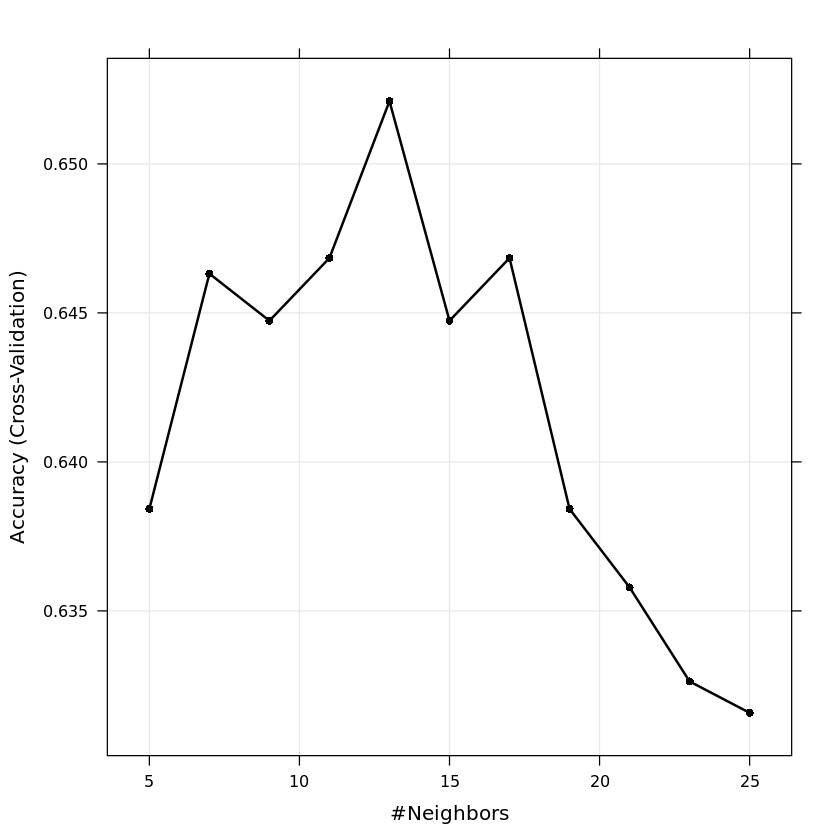

In [20]:
## We can plot the accuracy as a function of different hyperparameter to assist our selection of the hyperparameter
trellis.par.set(caretTheme())  ## here, we set the them for the plot
plot(knnMulti) 

The overall acurracy dropped significantly comparing to the binary results. When we take a closer look at the confusion matrix above, the corn and soy are mixed heavily by k-NN. This is understandable as we have seem in the feature space that they were quite hard to be separated based on our data.

## 6 - Activity  

Maybe you will ask can random forest help with the issue? It's a fun activity time for you to implement a random forest model for this multiclass classification problem. You should try to use a 10-fold cross validation strategy to figure out the best hyperparameter for your model. 

In [21]:
## STEP 1 - Setting training control

## Step 2 - setting searching grid for your hyperparameter tuning

## Step 3 - inplement your cross validation training

## Step 4 - visualize your cross validation results

## Step 5 - report your final model performance

## Step 6 - Compare with the k-NN model result
